<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Rename-your-notebook" data-toc-modified-id="Rename-your-notebook-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Rename your notebook</a></span></li><li><span><a href="#Build-the-vocabulary-by-selecting-top-k-frequent-words" data-toc-modified-id="Build-the-vocabulary-by-selecting-top-k-frequent-words-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Build the vocabulary by selecting top-k frequent words</a></span></li><li><span><a href="#Construct-the-term-document-matrix" data-toc-modified-id="Construct-the-term-document-matrix-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Construct the term document matrix</a></span></li><li><span><a href="#Perform-LSI-by-selecting-the-first-100-largest-singular-values-of-the-term-document-matrix" data-toc-modified-id="Perform-LSI-by-selecting-the-first-100-largest-singular-values-of-the-term-document-matrix-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Perform LSI by selecting the first 100 largest singular values of the term document matrix</a></span></li><li><span><a href="#Transform-the-given-query" data-toc-modified-id="Transform-the-given-query-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Transform the given query</a></span><ul class="toc-item"><li><span><a href="#Treat-the-query-as-another-document" data-toc-modified-id="Treat-the-query-as-another-document-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Treat the query as another document</a></span></li><li><span><a href="#Compute-the-query-vector-from-its-document-vector" data-toc-modified-id="Compute-the-query-vector-from-its-document-vector-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Compute the query vector from its document vector</a></span></li></ul></li><li><span><a href="#Retrieve-top-10-relevant-documents" data-toc-modified-id="Retrieve-top-10-relevant-documents-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Retrieve top-10 relevant documents</a></span><ul class="toc-item"><li><span><a href="#Fill-in-the-correct-parameters-in-the-following-function" data-toc-modified-id="Fill-in-the-correct-parameters-in-the-following-function-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Fill in the correct parameters in the following function</a></span></li></ul></li><li><span><a href="#Compute-F1-score-at-10-between-the-oracle-and-your-result" data-toc-modified-id="Compute-F1-score-at-10-between-the-oracle-and-your-result-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Compute F1-score at 10 between the oracle and your result</a></span></li><li><span><a href="#Compute-the-term-vectors-using-two-principal-concepts" data-toc-modified-id="Compute-the-term-vectors-using-two-principal-concepts-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Compute the term vectors using two principal concepts</a></span></li><li><span><a href="#Explain-the-scatter-plot-of-the-term-vectors" data-toc-modified-id="Explain-the-scatter-plot-of-the-term-vectors-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Explain the scatter plot of the term vectors</a></span></li><li><span><a href="#Submit-your-notebook" data-toc-modified-id="Submit-your-notebook-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Submit your notebook</a></span></li></ul></div>

# Distributed Information Systems

***Virtual Midterm Exam, Fall Semester 2020***

The following materials are allowed: exercise sheets and solutions, past exams with your own solution, personally written notes and personally collected documentation.

## Rename your notebook
Replace SciperNo with your **personal SCIPER Number**.

In [7]:
#Required libraries

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import math
from nltk.stem import PorterStemmer, WordNetLemmatizer
import os
import string
import numpy as np
from collections import Counter
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from collections import Counter
from operator import itemgetter
from pprint import pprint
import nltk
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english')).union(set(stopwords.words('french')))

[nltk_data] Downloading package punkt to /Users/fritt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/fritt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def read_corpus():
    '''Reads corpus from files.'''
    
    documents = []
    orig_docs = []
    DIR = './'
    tknzr = TweetTokenizer()
    with open("epfldocs.txt", encoding = "utf-8") as f:
        content = f.readlines()
    for text in content:
        orig_docs.append(text)
        # split into words
        tokens = tknzr.tokenize(text)
        # convert to lower case
        tokens = [w.lower() for w in tokens]
        # remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        # filter out stop words
        words = [w for w in words if not w in stop_words]

        documents.append(' '.join(words))
    return documents, orig_docs

In [9]:
documents, orig_docs = read_corpus()

In [10]:
assert(len(documents) == 1075)

# Latent Semantic Indexing (LSI)

## Build the vocabulary by selecting top-k frequent words

In [11]:
def create_vocabulary_frequency(corpus, vocab_len):
    '''Select top-k (k = vocab_len) words in term of frequencies as vocabulary'''
    
    count = {} # dictionary that contains the frequency of each word count[word] = freq
    for document in corpus:
        for word in document.split():
            # count = 0 if count == N else N+1 
            count[word] = 1 if word not in count else count[word] + 1
    
    sorted_count_by_freq = sorted(count.items(), key=lambda kv: kv[1], reverse=True)
    vocabulary = [x[0] for x in sorted_count_by_freq[:vocab_len+1]]
    
    return vocabulary


In [12]:
vocab_freq = create_vocabulary_frequency(documents, 1000)


## Construct the term document matrix
In this question, you need to construct the term document matrix given the vocabulary and the set of documents.
The value of a cell (i,j) is the term frequency of the term i in document j.
This is **different** from the definition from the lecture.

In [13]:
def construct_term_document_matrix(vocabulary, documents):
    matrix = np.zeros((len(vocabulary), len(documents)))
    for j, document in enumerate(documents):
        counter = Counter(document.split())
        
        for i, word in enumerate(vocabulary):

            matrix[i, j] = counter[word]
            
            # (term frequency of the the term i, document j)


    print(matrix)
    return matrix

In [14]:
term_doc_matrix_freq = construct_term_document_matrix(vocab_freq, documents)

[[0. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Perform LSI by selecting the first 100 largest singular values of the term document matrix  
Hint 1: np.linalg.svd(M, full_matrices=False) performs SVD on the matrix $\mathbf{M}$ and returns $\mathbf{K}, \mathbf{S}, \mathbf{D}^T$

 -  $\mathbf{K}, \mathbf{D}^T$ are matrices with orthonormal columns
 -  $\mathbf{S}$ is a **vector** of singular values in a **descending** order
 
Hint 2: np.diag(V) converts a vector to a diagonal matrix

Hint 3: To select 
 - The first k rows of a matrix A, use A[0:k, :]
 - The first k columns of a matrix A, use A[:, 0:k]
 - The submatrix from first k rows and k columns of a matrix A, use A[0:k, 0:k]

In [15]:
# Input: a term document matrix and the number of singular values that will be selected
# Output: K_s, S_s, Dt_s are similar to the defintion in the lecture
def truncated_svd(term_doc_matrix, num_val):
    K, S, Dt = np.linalg.svd(term_doc_matrix, full_matrices=False)
    K_sel = K[:,0:num_val]
    S_sel = np.diag(S)[0:num_val,0:num_val]
    Dt_sel = Dt[0:num_val,:]
    
    return K_sel, S_sel, Dt_sel

In [24]:
K_s, S_s, Dt_s = truncated_svd(term_doc_matrix_freq, 100)
print(K_s.shape)

(1001, 100)


## Transform the given query 

In this question, you need to construct a vector representation for the following query:

In [17]:
query = ['epfl']

### Treat the query as another document 

Hint: vocabulary.index(word) returns the index of the word if the word is in the vocabulary

In [18]:
def query_to_document_vector(query, vocabulary):
    vector = np.zeros(len(vocabulary))
    for word in query:
        try:
            # (term frequency of the the term i, document j)
            vector[vocabulary.index(word)] += 1
            
        except:
            # if query word is not in vocabulary, ignore it
            pass
    return vector

### Compute the query vector from its document vector

Hint: 
 -  To compute inverse of a matrix M, use np.linalg.inv(M)
 -  To compute the dot product of A, B, use np.dot(A,B)

In [19]:
def construct_query_vector(query, vocabulary, K_s, S_s, Dt_s):
    q = query_to_document_vector(query, vocabulary)
    mapper = np.dot(K_s, np.linalg.inv(S_s))
    q_trans =  np.dot(q, mapper)
    return q_trans

In [20]:
query_vector_freq = construct_query_vector(query, vocab_freq, K_s, S_s, Dt_s)

(1001, 100)
(100, 100)
(1001, 100)
(1001,)
(100,)


## Retrieve top-10 relevant documents
In this question, you need to retrieve the top-10 documents that are relevant to the query using cosine similarity. You are given a function to compute the cosine simimlarity and a function that return the top-k documents given the query and document vectors.

In [40]:
from scipy import spatial
def cosine_similarity(v1, v2):
    
    sim = np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    
    return sim

In [41]:
def retrieve_documents(query_vector, top_k, doc_vecs):
    scores = [[cosine_similarity(query_vector, doc_vecs[:,d]), d] for d in range(len(documents))]
    scores.sort(key=lambda x: -x[0])
    doc_ids = []
    retrieved = []
    for i in range(top_k):
        doc_ids.append(scores[i][1])
        retrieved.append(orig_docs[scores[i][1]])
    return doc_ids, retrieved

### Fill in the correct parameters in the following function

In [42]:
retrieved_ids_freq, retrieved_docs_freq = retrieve_documents(query_vector_freq, 10, Dt_s)

/var/folders/pc/5ytjzw0165n86jc4_pv2802c0000gn/T/ipykernel_19351/616042572.py:4: RuntimeWarning: invalid value encountered in double_scalars
  sim = np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))


In [44]:
pprint(retrieved_docs_freq)

['Environnement, un marché en pleine croissance https://t.co/ThTcYLrMtn Avec '
 'Philippe Thalmann @EPFL\n',
 'Chocolate &amp; berries #vegan cheesecake for my @EPFL coworkers! ✌🏽🌱 '
 '#veganfood #EPFLfood https://t.co/wPlLsIt0KD\n',
 "L'app pour «liker» en direct les transports publics https://t.co/3HbkTnIE3Q "
 '#epfl\n',
 'signé @EPFL https://t.co/sRldB2O7PM\n',
 "L'électrochimie débusque les protéines résistantes aux antibiotiques "
 'https://t.co/BHlj5WHMbC Avec Hubert Girault @EPFL\n',
 '#ff @Kikohs and his beautiful artworks. Some of them are displayed at @EPFL '
 'and featured on ZettaBytes! https://t.co/8F4BNL7aAs\n',
 'Ca court, ca court à #carandache #epfl #wwim15 #wwim15_igerslausanne '
 'https://t.co/0bNMBPx50k\n',
 'Femmes en politique, pour en finir avec les seconds rôles '
 'https://t.co/IgIkg8yrxy #epfl\n',
 'Le camion Cargo Congo du @theatredevidy est sur la #PlaceCosandey- ne '
 'manquez pas de venir découvrir ce spectacle de 10 mins jusqu’à 14h puis à '
 '16h @EPFL 

# Evaluation
In this question, we consider the scikit reference code as an “oracle” that supposedly gives the correct result. You need to compare your retrieval results with this oracle using the F1-score.

In [49]:
# Retrieval oracle 
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), vocabulary=vocab_freq, min_df = 1, stop_words = 'english')
features = tf.fit_transform(documents)
npm_tfidf = features.todense()

# Return all document ids that that have cosine similarity with the query larger than a threshold
def search_vec_sklearn(query, features, threshold=0.3):
    new_features = tf.transform([query])
    cosine_similarities = linear_kernel(new_features, features).flatten()
    related_docs_indices, cos_sim_sorted = zip(*sorted(enumerate(cosine_similarities), key=itemgetter(1), 
                                                       reverse=True))
    doc_ids = []
    for i, cos_sim in enumerate(cos_sim_sorted):
        if cos_sim < threshold:
            break
        doc_ids.append(related_docs_indices[i])
    return doc_ids

In [50]:
# gt_ids are the document ids retrieved by the oracle
gt_ids = search_vec_sklearn(" ".join(query), features)

## Compute F1-score at 10 between the oracle and your result

In [64]:
def compute_recall_at_k(predicted, oracle, k):
    predicted = predicted[:k]
    oracle = oracle

    tp = set(predicted).intersection(set(oracle))
    recall = len(tp)/len(set(oracle))
    
    
    return recall

In [65]:
def compute_precision_at_k(predicted, oracle, k):
    predicted = predicted[:k]
    oracle = oracle  
    tp = set(predicted).intersection(set(oracle))
    
    precision = len(tp)/k
    
    return precision

In [66]:
def f1score(predicted, oracle, k):
    recall = compute_recall_at_k(predicted, oracle, k)
    precision = compute_precision_at_k(predicted, oracle, k)
    
    f1 = 2*(precision*recall)/(precision+recall)
    
    
    return f1

In [69]:
recall = compute_recall_at_k(retrieved_ids_freq, gt_ids, 10)
precision = compute_precision_at_k(retrieved_ids_freq, gt_ids, 10)
print(precision, recall)
f1score(retrieved_ids_freq, gt_ids, 10)

0.9 0.2571428571428571


0.39999999999999997

# Visualization

## Compute the term vectors using two principal concepts
Hint: you can reuse a method from the above

In [72]:
# term_vecs_freq is a matrix of size (num_terms, 2)
K_s, S_s, Dt_s = truncated_svd(term_doc_matrix_freq, 2)
term_vecs_freq = K_s

## Explain the scatter plot of the term vectors

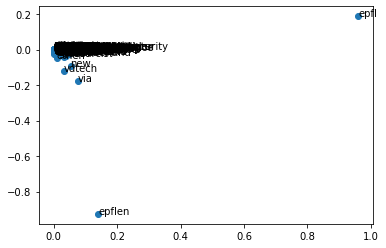

In [73]:
plt.scatter(term_vecs_freq[:, 0], term_vecs_freq[:, 1])
for i, t in enumerate(vocab_freq):
    plt.annotate(t, (term_vecs_freq[i, 0], term_vecs_freq[i, 1]))
plt.show()

Hint: Do you see any outliers? What is a possible explanation?

*YOUR ANSWER HERE*

## Submit your notebook

* Link: https://moodle.epfl.ch/mod/quiz/view.php?id=1016203
* Password: on the virtual blackboard